# Inverse Kinematics of a 2-Link Planar Robot Arm

Given a planar 2-link arm with link lengths $L_1, L_2 > 0$ and joint angles $\theta_1, \theta_2$,  
the end-effector (EE) Cartesian position $(x,y)$ is


$$
\begin{aligned}
x(\theta_1,\theta_2) &= L_1\cos\theta_1 + L_2\cos(\theta_1+\theta_2), \\
y(\theta_1,\theta_2) &= L_1\sin\theta_1 + L_2\sin(\theta_1+\theta_2).
\end{aligned}
$$

The **inverse kinematics (IK)** asks: for a desired target $(x_d,y_d)$, find joint angles $(\theta_1,\theta_2)$ such that

$$
(x(\theta_1,\theta_2),\, y(\theta_1,\theta_2)) = (x_d,\, y_d).
$$

This yields the nonlinear system

$$
F(\theta_1,\theta_2) =
\begin{bmatrix}
F_1(\theta_1,\theta_2) \\[2mm]
F_2(\theta_1,\theta_2)
\end{bmatrix}
=
\begin{bmatrix}
x(\theta_1,\theta_2)-x_d \\[2mm]
y(\theta_1,\theta_2)-y_d
\end{bmatrix}
= \mathbf{0}.
$$

**Note** 
A target is reachable iff

$$
|L_1-L_2| \;\le\; \sqrt{x_d^2+y_d^2} \;\le\; L_1+L_2.
$$

When reachable, two solutions usually exist: **elbow-up** and **elbow-down**.  
Newton's method will converge to the solution “near” the initial guess.

## Newton's Method for Systems

Given $x_k = (\theta_1^{(k)}, \theta_2^{(k)})^\top$, compute the Newton step $s_k$ from

$$
J_F(x_k)\,s_k = -F(x_k), \qquad
x_{k+1} = x_k + \alpha_k s_k, \quad \alpha_k \in (0,1].
$$

We use backtracking (Armijo) on a merit function $\phi(x)=\tfrac12\|F(x)\|_2^2$ to choose $\alpha_k$.

**Jacobian.** Since $x_d,y_d$ are constants:

$$
J_F(\theta_1,\theta_2) =
\begin{bmatrix}
\frac{\partial x}{\partial \theta_1} & \frac{\partial x}{\partial \theta_2} \\[2mm]
\frac{\partial y}{\partial \theta_1} & \frac{\partial y}{\partial \theta_2}
\end{bmatrix}
=
\begin{bmatrix}
- L_1\sin\theta_1 - L_2\sin(\theta_1+\theta_2) & -L_2\sin(\theta_1+\theta_2) \\[2mm]
\;\; L_1\cos\theta_1 + L_2\cos(\theta_1+\theta_2) & \;\; L_2\cos(\theta_1+\theta_2)
\end{bmatrix}.
$$

**Stopping criteria.** We stop when either

$$
\|F(x_k)\|_\infty \le \varepsilon_f, \quad
\|x_{k+1}-x_k\|_\infty \le \varepsilon_x, \quad
k \ge k_{\max}.
$$

**Local convergence.** If $F$ is $C^1$ near a solution $x^\star$ and $J_F(x^\star)$ is nonsingular  
(i.e., we are not at a kinematic singularity where $\det J_F = 0$), then for a good initial guess,  
Newton's method is quadratically convergent.

In [ ]:
import numpy as np
from numpy.linalg import norm, solve, LinAlgError
from dataclasses import dataclass
import math

In [ ]:
def forward_xy(theta, L1, L2):
    """Return x,y for joint angles theta=[θ1,θ2]."""
    t1, t2 = theta
    x = L1*np.cos(t1) + L2*np.cos(t1 + t2)
    y = L1*np.sin(t1) + L2*np.sin(t1 + t2)
    return np.array([x, y])

def residual(theta, L1, L2, xd, yd):
    """F(theta) = [x(theta)-xd, y(theta)-yd]."""
    return forward_xy(theta, L1, L2) - np.array([xd, yd])

def jacobian(theta, L1, L2):
    """Jacobian of [x(theta), y(theta)] w.r.t. [θ1, θ2]."""
    t1, t2 = theta
    s1 = np.sin(t1)
    c1 = np.cos(t1)
    s12 = np.sin(t1 + t2)
    c12 = np.cos(t1 + t2)
    J = np.array([
        [-L1*s1 - L2*s12, -L2*s12],
        [ L1*c1 + L2*c12,  L2*c12]
    ])
    return J


In [ ]:
@dataclass
class NewtonResult:
    theta: np.ndarray
    f_norm: float
    iters: int
    converged: bool
    history: list  # list of dicts per iteration

def newton_ik(L1, L2, xd, yd, theta0, 
              tol_f=1e-10, tol_x=1e-12, kmax=50, 
              damping=True, c1=1e-4, alpha_min=1e-6, verbose=False):
    """
    Newton's method for 2D IK with optional Armijo backtracking.
    Returns NewtonResult.
    """
    th = np.array(theta0, dtype=float)
    hist = []

    def phi(z):
        Fz = residual(z, L1, L2, xd, yd)
        return 0.5*float(Fz @ Fz)

    for k in range(kmax):
        F = residual(th, L1, L2, xd, yd)
        f_inf = norm(F, ord=np.inf)
        hist.append({"k": k, "theta": th.copy(), "f_inf": f_inf})

        if verbose:
            print(f"[{k:02d}] ||F||_inf = {f_inf:.3e},  theta = {th}")

        if f_inf <= tol_f:
            return NewtonResult(th, f_inf, k, True, hist)

        J = jacobian(th, L1, L2)

        # Solve J s = -F (with tiny Tikhonov if needed)
        try:
            s = solve(J, -F)
        except LinAlgError:
            s = solve(J + 1e-10*np.eye(2), -F)

        # Damped step
        alpha = 1.0
        if damping:
            phi0 = phi(th)
            # Use a simple sufficient decrease condition on phi
            while alpha > alpha_min and phi(th + alpha*s) > (1 - c1*alpha)*phi0:
                alpha *= 0.5

        th_new = th + alpha*s
        if norm(th_new - th, ord=np.inf) <= tol_x:
            th = th_new
            F = residual(th, L1, L2, xd, yd)
            return NewtonResult(th, norm(F, ord=np.inf), k+1, True, hist)

        th = th_new

    # Out of iterations
    F = residual(th, L1, L2, xd, yd)
    return NewtonResult(th, norm(F, ord=np.inf), kmax, False, hist)


##  Experiments

We select realistic link lengths and at least three reachable targets.  
Let $L_1=1.0$, $L_2=0.8$. The reachable annulus is
$|L_1-L_2|=0.2 \le r \le L_1+L_2=1.8$.

We will test the following targets:
- $T_1=(1.10,\,0.60)$
- $T_2=(0.30,\,1.40)$
- $T_3=(1.50,\,0.10)$

For each target we try two different initial guesses to obtain **elbow-down** ($\theta_2<0$) and
**elbow-up** ($\theta_2>0$) configurations.



Target: (1.10, 0.60)
  init 1: converged in 5 iters, θ1=1.191061, θ2=-1.614560,  ||F||_inf=1.11e-16


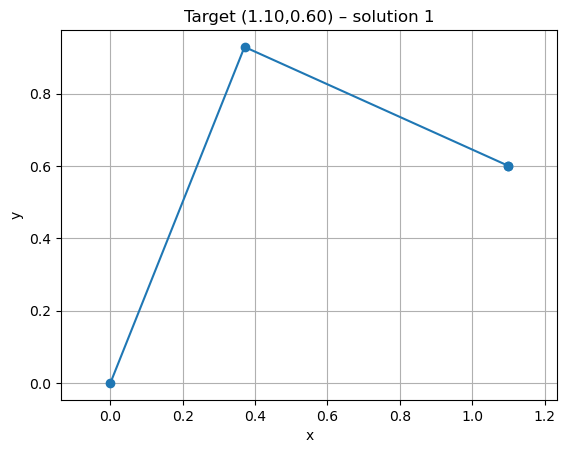

  init 2: converged in 5 iters, θ1=-0.192367, θ2=1.614560,  ||F||_inf=7.38e-12


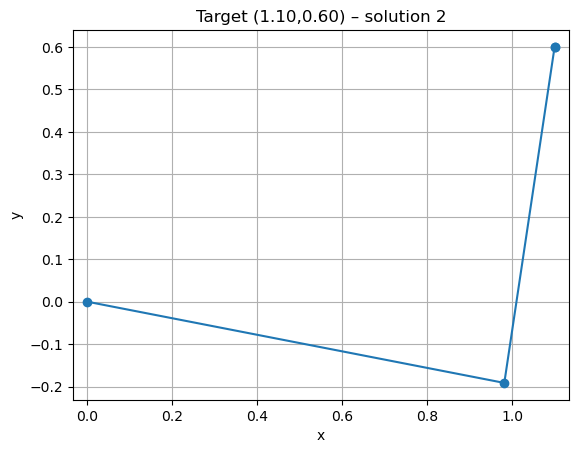


Target: (0.30, 1.40)
  init 1: converged in 8 iters, θ1=1.930245, θ2=-1.311656,  ||F||_inf=1.06e-12


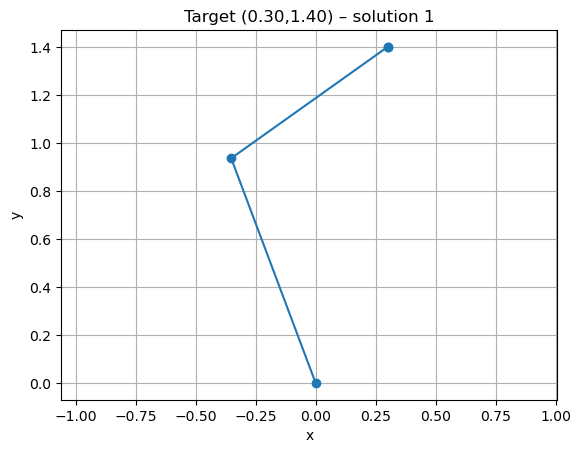

  init 2: converged in 5 iters, θ1=0.789161, θ2=1.311656,  ||F||_inf=1.20e-11


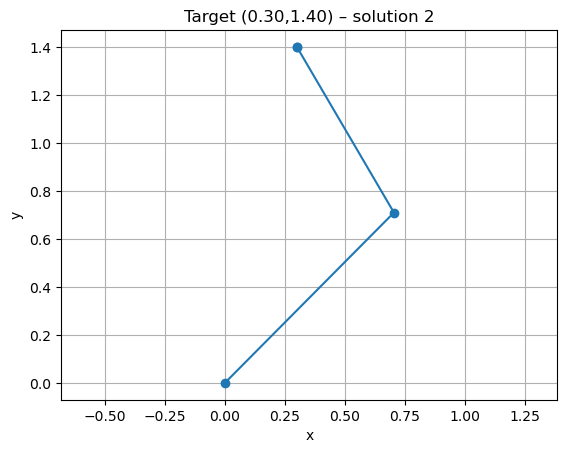


Target: (1.50, 0.10)
  init 1: converged in 5 iters, θ1=0.579318, θ2=-1.172878,  ||F||_inf=7.00e-13


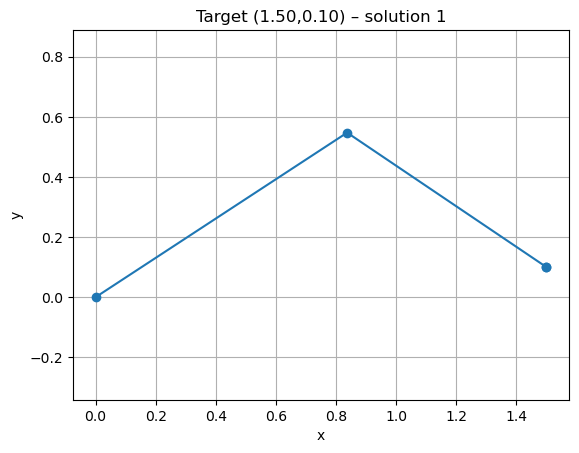

  init 2: converged in 7 iters, θ1=-0.446181, θ2=1.172878,  ||F||_inf=8.33e-17


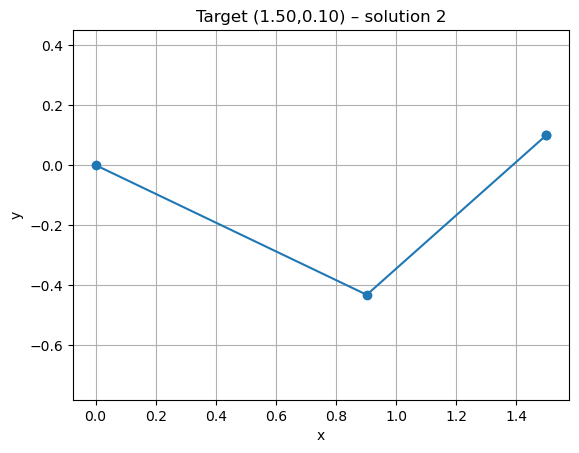

In [ ]:
import matplotlib.pyplot as plt

L1, L2 = 1.0, 0.8
targets = [(1.10, 0.60), (0.30, 1.40), (1.50, 0.10)]

def plot_arm(theta, L1, L2, target=None, title=None):
    t1, t2 = theta
    p0 = np.array([0.0, 0.0])
    p1 = np.array([L1*np.cos(t1), L1*np.sin(t1)])
    p2 = forward_xy(theta, L1, L2)
    xs = [p0[0], p1[0], p2[0]]
    ys = [p0[1], p1[1], p2[1]]

    plt.figure()
    plt.plot(xs, ys, marker='o')
    plt.axis('equal')
    plt.grid(True)
    if target is not None:
        plt.scatter([target[0]],[target[1]])
    if title:
        plt.title(title)
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()

def try_target(xd, yd):
    # Two initial guesses: elbow-down (θ2 negative) and elbow-up (θ2 positive)
    guesses = [np.array([0.5, -0.5]), np.array([0.5, 0.8])]
    results = []
    for g in guesses:
        res = newton_ik(L1, L2, xd, yd, theta0=g, damping=True, verbose=False)
        results.append(res)
    return results

all_results = []
for (xd, yd) in targets:
    res_pair = try_target(xd, yd)
    all_results.append((xd, yd, res_pair))

# Print and plot
for (xd, yd, pair) in all_results:
    print(f"\nTarget: ({xd:.2f}, {yd:.2f})")
    for i, res in enumerate(pair):
        status = "converged" if res.converged else "NOT converged"
        t1, t2 = res.theta
        print(f"  init {i+1}: {status} in {res.iters} iters,"
              f" θ1={t1:.6f}, θ2={t2:.6f},  ||F||_inf={res.f_norm:.2e}")
        if res.converged:
            plot_arm(res.theta, L1, L2, target=(xd,yd), 
                     title=f"Target ({xd:.2f},{yd:.2f}) – solution {i+1}")


In [ ]:
## seria bueno inetgrarlo

def is_reachable(L1, L2, xd, yd, tol=1e-12):
    r = math.hypot(xd, yd)
    return (abs(L1 - L2) - tol) <= r <= (L1 + L2 + tol)

def solve_or_report(L1, L2, xd, yd, guess=np.array([0.0, 0.5])):
    if not is_reachable(L1, L2, xd, yd):
        print(f"Target ({xd:.2f},{yd:.2f}) is not reachable for L1={L1}, L2={L2}.")
        return None
    res = newton_ik(L1, L2, xd, yd, theta0=guess)
    print(f"Solved: θ = {res.theta}, ||F||_inf={res.f_norm:.2e}, iters={res.iters}")
    return res

solve_or_report(L1, L2, xd=0.05, yd=0.00)  


Target (0.05,0.00) is not reachable for L1=1.0, L2=0.8.
